In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install transformers scikit-image -q


In [16]:
import torch
import os
from pathlib import Path

print(f"GPU Available: {torch.cuda.is_available()}")
print(f"GPU Name: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'None'}")

# Check data
octa_path = Path('/kaggle/input/octa-500processed')
print(f"\nDataset contents:")
for item in sorted(octa_path.iterdir()):
    print(f"  - {item.name}")

GPU Available: True
GPU Name: Tesla P100-PCIE-16GB

Dataset contents:
  - processed_3mm
  - processed_6mm


In [4]:
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import cv2
import numpy as np
from pathlib import Path
from typing import Dict, List, Optional
import logging
from tqdm import tqdm
import matplotlib.pyplot as plt
import json
import time
from transformers import ViTMAEForPreTraining, ViTMAEConfig
print(torch.cuda.is_available())

2025-10-09 01:34:46.613735: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759973686.855210      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759973686.928358      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


True


In [7]:
class PreprocessedOCTA500Dataset(Dataset):
    """
    Dataset loader for preprocessed OCTA-500 data
    
    Supports two scenarios:
    1. Preprocessed data in input dataset: /kaggle/input/octa-500-v1/processed_3mm/
    2. Preprocessed data in working dir: /kaggle/working/processed_3mm/
    """
    
    def __init__(
        self, 
        data_dirs: List[str],
        target_type: str = 'intensity',
        image_size: int = 224,
        normalize: bool = True,
        augment: bool = False
    ):
        self.data_dirs = [Path(d) for d in data_dirs]
        self.target_type = target_type
        self.image_size = image_size
        self.normalize = normalize
        self.augment = augment
        
        # Collect all image paths
        self.image_paths = []
        for data_dir in self.data_dirs:
            target_dir = data_dir / target_type
            
            if not target_dir.exists():
                print(f"WARNING: Directory not found: {target_dir}")
                continue
            
            # Get all .png files
            image_files = sorted(target_dir.glob('*.png'))
            self.image_paths.extend(image_files)
            print(f"Found {len(image_files)} images in {target_dir}")
        
        if len(self.image_paths) == 0:
            raise ValueError(f"No images found! Check your data directories: {data_dirs}")
        
        print(f"\nTotal images loaded: {len(self.image_paths)}")
        print(f"Using target type: {target_type}")
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        # Load preprocessed image (256x256 uint8)
        img_path = self.image_paths[idx]
        image = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
        
        if image is None:
            raise ValueError(f"Failed to load image: {img_path}")
        
        # Resize from 256 to 224 for ViT
        if self.image_size != image.shape[0]:
            image = cv2.resize(image, (self.image_size, self.image_size), 
                             interpolation=cv2.INTER_AREA)
        
        # Convert to tensor and normalize
        image = torch.from_numpy(image).float().unsqueeze(0)  # [1, H, W]
        
        if self.normalize:
            image = image / 255.0
        
        # Optional augmentation
        if self.augment and torch.rand(1) < 0.5:
            noise = torch.randn_like(image) * 0.1
            image = torch.clamp(image + noise, 0, 1)
        
        return {'image': image}

In [8]:
class MAEUniformOCTA:
    """MAE-Uniform implementation for OCTA-500"""
    
    def __init__(
        self,
        mask_ratio: float = 0.75,
        image_size: int = 224,
        patch_size: int = 16,
        device: str = 'cuda'
    ):
        self.mask_ratio = mask_ratio
        self.image_size = image_size
        self.patch_size = patch_size
        self.device = device
        
        print(f"\nInitializing MAE-Uniform:")
        print(f"  - Image size: {image_size}x{image_size}")
        print(f"  - Patch size: {patch_size}x{patch_size}")
        print(f"  - Mask ratio: {mask_ratio}")
        print(f"  - Device: {device}")
        
        self.model = self._create_model()
        self.optimizer = None
        self.scheduler = None
        
        # Count parameters
        total_params = sum(p.numel() for p in self.model.parameters())
        trainable_params = sum(p.numel() for p in self.model.parameters() if p.requires_grad)
        print(f"  - Total parameters: {total_params:,}")
        print(f"  - Trainable parameters: {trainable_params:,}")
    
    def _create_model(self):
        """Create ViT-MAE model"""
        config = ViTMAEConfig(
            image_size=self.image_size,
            patch_size=self.patch_size,
            num_channels=1,  # Grayscale OCT-A
            hidden_size=768,
            num_hidden_layers=12,
            num_attention_heads=12,
            intermediate_size=3072,
            mask_ratio=self.mask_ratio,
        )
        
        model = ViTMAEForPreTraining(config).to(self.device)
        return model
    
    def setup_optimizer(self, lr=1e-4, weight_decay=0.05, max_epochs=100):
        """Setup AdamW optimizer with cosine scheduler"""
        self.optimizer = torch.optim.AdamW(
            self.model.parameters(), 
            lr=lr, 
            weight_decay=weight_decay
        )
        self.scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            self.optimizer, T_max=max_epochs
        )
        print(f"\nOptimizer setup:")
        print(f"  - Learning rate: {lr}")
        print(f"  - Weight decay: {weight_decay}")
        print(f"  - Scheduler: CosineAnnealing (T_max={max_epochs})")
    
    def train_step(self, batch):
        """Single training step"""
        self.model.train()
        images = batch['image'].to(self.device)
        
        # Forward pass
        outputs = self.model(pixel_values=images)
        loss = outputs.loss
        
        # Backward pass
        self.optimizer.zero_grad()
        loss.backward()
        
        # Gradient clipping for stability
        torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
        
        self.optimizer.step()
        
        return loss.item()
    
    def save_checkpoint(self, path, epoch, loss):
        """Save model checkpoint"""
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'scheduler_state_dict': self.scheduler.state_dict() if self.scheduler else None,
            'loss': loss,
            'config': {
                'mask_ratio': self.mask_ratio,
                'image_size': self.image_size,
                'patch_size': self.patch_size
            }
        }
        torch.save(checkpoint, path)
    
    def load_checkpoint(self, path):
        """Load model checkpoint"""
        checkpoint = torch.load(path, map_location=self.device)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        if self.optimizer and 'optimizer_state_dict' in checkpoint:
            self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        if self.scheduler and checkpoint.get('scheduler_state_dict'):
            self.scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        return checkpoint['epoch'], checkpoint['loss']


class MAETrainerKaggle:
   
    
    def __init__(self, config: Dict):
        self.config = config
        self.device = config.get('device', 'cuda' if torch.cuda.is_available() else 'cpu')
        
        # Setup logging
        logging.basicConfig(
            level=logging.INFO,
            format='%(asctime)s - %(levelname)s - %(message)s'
        )
        self.logger = logging.getLogger(__name__)
        
        # Create output directory
        self.output_dir = Path(config['output_dir'])
        self.output_dir.mkdir(parents=True, exist_ok=True)
        
        # Initialize tracking
        self.train_losses = []
        self.epoch_times = []
        self.best_loss = float('inf')
    
    def create_dataloader(self):
        """Create OCTA-500 dataloader"""
        print("\n" + "=" * 60)
        print("CREATING DATALOADER")
        print("=" * 60)
        
        dataset = PreprocessedOCTA500Dataset(
            data_dirs=self.config['data_dirs'],
            target_type=self.config.get('target_type', 'intensity'),
            image_size=self.config.get('image_size', 224),
            normalize=True,
            augment=self.config.get('augment', False)
        )
        
        dataloader = DataLoader(
            dataset,
            batch_size=self.config['batch_size'],
            shuffle=True,
            num_workers=self.config.get('num_workers', 2),
            pin_memory=True,
            drop_last=True
        )
        
        print(f"\nDataLoader created:")
        print(f"  - Total samples: {len(dataset)}")
        print(f"  - Batch size: {self.config['batch_size']}")
        print(f"  - Batches per epoch: {len(dataloader)}")
        print(f"  - Num workers: {self.config.get('num_workers', 2)}")
        
        return dataloader
    
    def train(self, mae_model: MAEUniformOCTA, train_loader: DataLoader, epochs: int):
      
        
        print("\n" + "=" * 60)
        print("STARTING TRAINING")
        print("=" * 60)
        print(f"Device: {self.device}")
        print(f"Epochs: {epochs}")
        print(f"Total training samples: {len(train_loader.dataset)}")
        print(f"Batches per epoch: {len(train_loader)}")
        print("=" * 60 + "\n")
        
        start_time = time.time()
        
        for epoch in range(epochs):
            epoch_start = time.time()
            epoch_losses = []
            
            # Training loop with progress bar
            pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
            for batch_idx, batch in enumerate(pbar):
                loss = mae_model.train_step(batch)
                epoch_losses.append(loss)
                
                # Update progress bar
                pbar.set_postfix({
                    'loss': f'{loss:.4f}',
                    'avg_loss': f'{np.mean(epoch_losses):.4f}'
                })
            
            # Epoch statistics
            avg_loss = np.mean(epoch_losses)
            epoch_time = time.time() - epoch_start
            self.train_losses.append(avg_loss)
            self.epoch_times.append(epoch_time)
            
            # Learning rate scheduling
            if mae_model.scheduler:
                mae_model.scheduler.step()
                current_lr = mae_model.optimizer.param_groups[0]['lr']
            else:
                current_lr = self.config.get('lr', 1e-4)
            
            # Calculate ETA
            elapsed_time = time.time() - start_time
            avg_epoch_time = np.mean(self.epoch_times)
            eta_seconds = avg_epoch_time * (epochs - epoch - 1)
            eta_hours = eta_seconds / 3600
            
            # Logging
            self.logger.info(
                f"Epoch {epoch+1}/{epochs} | "
                f"Loss: {avg_loss:.4f} | "
                f"LR: {current_lr:.6f} | "
                f"Time: {epoch_time:.1f}s | "
                f"ETA: {eta_hours:.1f}h"
            )
            
            # Save best model
            if avg_loss < self.best_loss:
                self.best_loss = avg_loss
                best_path = self.output_dir / "mae_best.pth"
                mae_model.save_checkpoint(best_path, epoch+1, avg_loss)
                self.logger.info(f"  → Best model saved! (loss: {avg_loss:.4f})")
            
            # Save checkpoints (only at key epochs to save space)
            if (epoch + 1) in [10, 25, 50, 75, 100]:
                checkpoint_path = self.output_dir / f"mae_epoch_{epoch+1}.pth"
                mae_model.save_checkpoint(checkpoint_path, epoch+1, avg_loss)
                self.logger.info(f"  → Checkpoint saved: epoch_{epoch+1}.pth")
            
            # Plot every 10 epochs
            if (epoch + 1) % 10 == 0:
                self._plot_training_curve()
        
        # Training complete
        total_time = time.time() - start_time
        self.logger.info("\n" + "=" * 60)
        self.logger.info("TRAINING COMPLETE!")
        self.logger.info(f"Total time: {total_time/3600:.2f} hours")
        self.logger.info(f"Best loss: {self.best_loss:.4f}")
        self.logger.info(f"Final loss: {self.train_losses[-1]:.4f}")
        self.logger.info("=" * 60)
        
        # Save final model
        final_path = self.output_dir / "mae_final.pth"
        mae_model.save_checkpoint(final_path, epochs, self.train_losses[-1])
        
        # Save training history
        self._save_training_history()
        self._plot_training_curve()
        
        return self.train_losses
    
    def _save_training_history(self):
        """Save training history to JSON"""
        history = {
            'train_losses': [float(x) for x in self.train_losses],
            'epoch_times': [float(x) for x in self.epoch_times],
            'best_loss': float(self.best_loss),
            'config': self.config
        }
        
        history_path = self.output_dir / 'training_history.json'
        with open(history_path, 'w') as f:
            json.dump(history, f, indent=2)
    
    def _plot_training_curve(self):
        """Plot training loss curve"""
        plt.figure(figsize=(12, 5))
        
        # Loss curve
        plt.subplot(1, 2, 1)
        plt.plot(self.train_losses, linewidth=2, color='#2E86AB')
        plt.xlabel('Epoch', fontsize=12)
        plt.ylabel('Loss', fontsize=12)
        plt.title('MAE-Uniform Training Loss', fontsize=14, fontweight='bold')
        plt.grid(True, alpha=0.3)
        
        # Time per epoch
        plt.subplot(1, 2, 2)
        plt.plot(self.epoch_times, linewidth=2, color='#A23B72')
        plt.xlabel('Epoch', fontsize=12)
        plt.ylabel('Time (seconds)', fontsize=12)
        plt.title('Time per Epoch', fontsize=14, fontweight='bold')
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plot_path = self.output_dir / 'training_curves.png'
        plt.savefig(plot_path, dpi=300, bbox_inches='tight')
        plt.close()


CONFIGURATION

In [17]:
def create_kaggle_config(use_preprocessed_input=True):
   
    
    if use_preprocessed_input:
        
        data_dirs = [
             '/kaggle/input/octa-500processed/processed_3mm',
            '/kaggle/input/octa-500processed/processed_6mm'
        ]
    else:
        
        data_dirs = [
            '/kaggle/working/processed_3mm',
            '/kaggle/working/processed_6mm'
        ]
    
    return {
        # Data paths
        'data_dirs': data_dirs,
        
        # Training parameters
        'batch_size': 32,  # Adjust based on GPU memory
        'num_workers': 2,   # Kaggle has 4 CPU cores
        'epochs': 100,
        
        # Model parameters
        'image_size': 224,
        'patch_size': 16,
        'mask_ratio': 0.75,
        
        # Optimization
        'lr': 1e-4,
        'weight_decay': 0.05,
        
        # Data parameters
        'target_type': 'intensity',  # 'intensity', 'vesselness', or 'skeleton'
        'augment': False,
        
        # Output
        'output_dir': '/kaggle/working/mae_results',
        'device': 'cuda' if torch.cuda.is_available() else 'cpu'
    }


MAE TRAINING FUNCTION

In [18]:
def run_mae_on_kaggle(quick_test=False):
   
    # Create configuration
    config = create_kaggle_config(use_preprocessed_input=True)
    
    if quick_test:
        config['epochs'] = 5
        config['batch_size'] = 16
        print("\n⚠️  QUICK TEST MODE: Running 5 epochs only\n")
    
    # Print configuration
    print("=" * 60)
    print("MAE-UNIFORM TRAINING CONFIGURATION")
    print("=" * 60)
    for key, value in config.items():
        print(f"{key:20s}: {value}")
    print("=" * 60 + "\n")
    
    # Initialize trainer
    trainer = MAETrainerKaggle(config)
    
    # Create dataloader
    train_loader = trainer.create_dataloader()
    
    # Initialize MAE model
    mae_model = MAEUniformOCTA(
        mask_ratio=config['mask_ratio'],
        image_size=config['image_size'],
        patch_size=config['patch_size'],
        device=config['device']
    )
    mae_model.setup_optimizer(
        lr=config['lr'], 
        weight_decay=config['weight_decay'],
        max_epochs=config['epochs']
    )
    
    # Train
    losses = trainer.train(mae_model, train_loader, epochs=config['epochs'])
    
    return mae_model, losses, trainer

QUICK TEST

In [19]:
# Test with 5 epochs first (~10-15 minutes)
mae_model, losses, trainer = run_mae_on_kaggle(quick_test=True)


⚠️  QUICK TEST MODE: Running 5 epochs only

MAE-UNIFORM TRAINING CONFIGURATION
data_dirs           : ['/kaggle/input/octa-500processed/processed_3mm', '/kaggle/input/octa-500processed/processed_6mm']
batch_size          : 16
num_workers         : 2
epochs              : 5
image_size          : 224
patch_size          : 16
mask_ratio          : 0.75
lr                  : 0.0001
weight_decay        : 0.05
target_type         : intensity
augment             : False
output_dir          : /kaggle/working/mae_results
device              : cuda


CREATING DATALOADER
Found 600 images in /kaggle/input/octa-500processed/processed_3mm/intensity
Found 900 images in /kaggle/input/octa-500processed/processed_6mm/intensity

Total images loaded: 1500
Using target type: intensity

DataLoader created:
  - Total samples: 1500
  - Batch size: 16
  - Batches per epoch: 93
  - Num workers: 2

Initializing MAE-Uniform:
  - Image size: 224x224
  - Patch size: 16x16
  - Mask ratio: 0.75
  - Device: cuda
  - T

Epoch 5/5: 100%|██████████| 93/93 [00:19<00:00,  4.74it/s, loss=0.0223, avg_loss=0.0240]


UPDATED CONGIG

In [20]:
CONFIG = {
    'data_dirs': [
        '/kaggle/input/octa-500processed/processed_3mm',
        '/kaggle/input/octa-500processed/processed_6mm'
    ],
    'batch_size': 16,
    'num_workers': 2,
    'epochs': 100,  # ← Changed from 5 to 100
    'image_size': 224,
    'patch_size': 16,
    'mask_ratio': 0.75,
    'lr': 0.0001,
    'weight_decay': 0.05,
    'target_type': 'intensity',
    'augment': False,
    'output_dir': '/kaggle/working/mae_results',
    'device': 'cuda'
}

In [21]:
# Full 100-epoch training
mae_model, losses, trainer = run_mae_on_kaggle(quick_test=False)

MAE-UNIFORM TRAINING CONFIGURATION
data_dirs           : ['/kaggle/input/octa-500processed/processed_3mm', '/kaggle/input/octa-500processed/processed_6mm']
batch_size          : 32
num_workers         : 2
epochs              : 100
image_size          : 224
patch_size          : 16
mask_ratio          : 0.75
lr                  : 0.0001
weight_decay        : 0.05
target_type         : intensity
augment             : False
output_dir          : /kaggle/working/mae_results
device              : cuda


CREATING DATALOADER
Found 600 images in /kaggle/input/octa-500processed/processed_3mm/intensity
Found 900 images in /kaggle/input/octa-500processed/processed_6mm/intensity

Total images loaded: 1500
Using target type: intensity

DataLoader created:
  - Total samples: 1500
  - Batch size: 32
  - Batches per epoch: 46
  - Num workers: 2

Initializing MAE-Uniform:
  - Image size: 224x224
  - Patch size: 16x16
  - Mask ratio: 0.75
  - Device: cuda
  - Total parameters: 111,251,968
  - Trainable 

Epoch 100/100: 100%|██████████| 46/46 [00:16<00:00,  2.72it/s, loss=0.0239, avg_loss=0.0239]


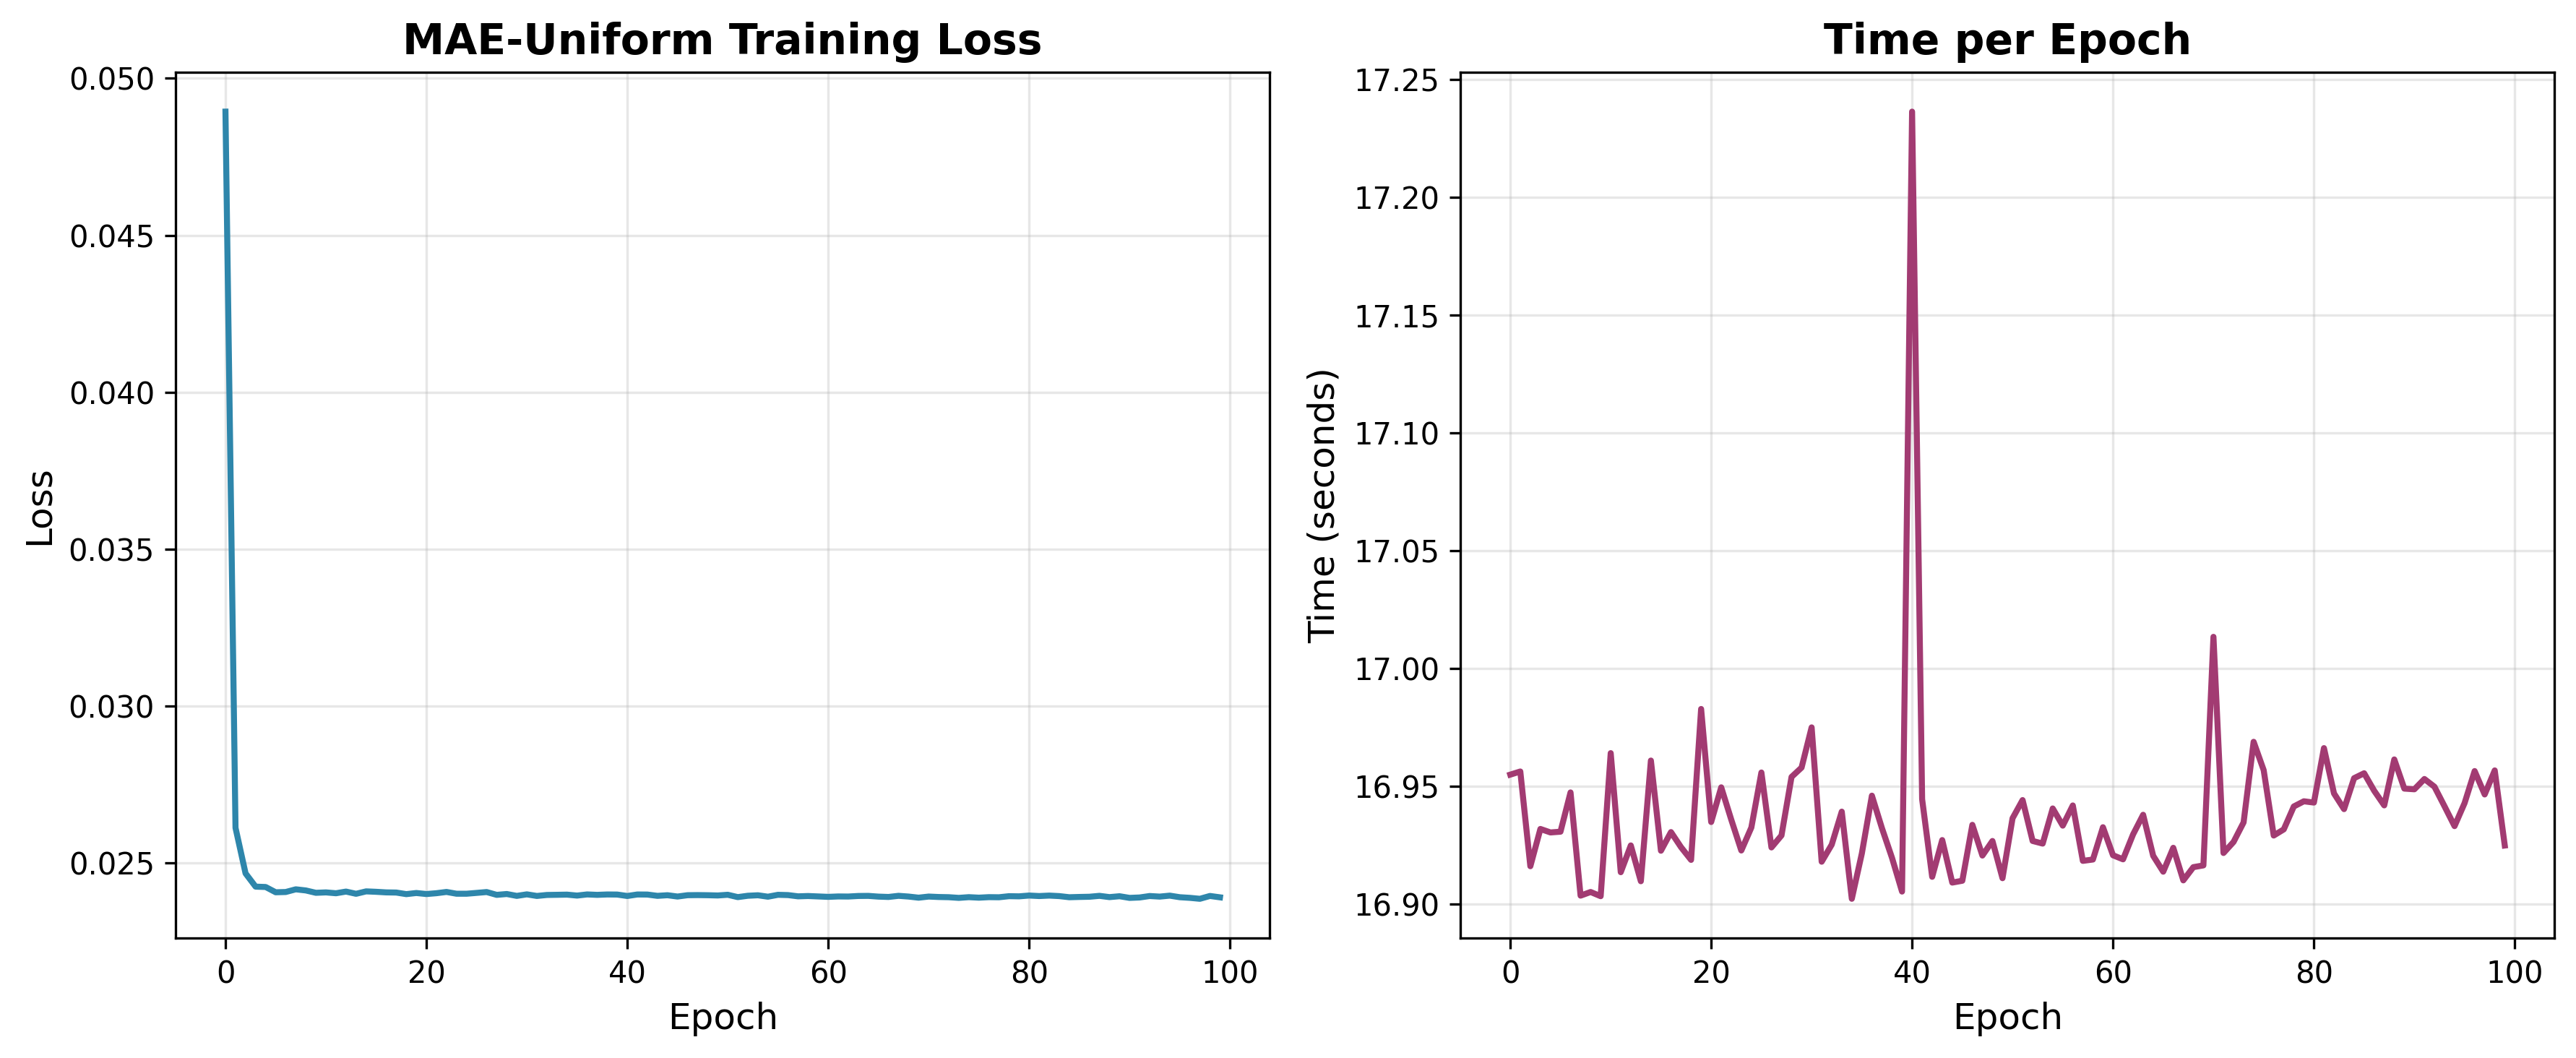

In [23]:
from IPython.display import Image as IPImage, display

# Display the training curve
display(IPImage(filename='/kaggle/working/mae_results/training_curves.png'))